## GD_NLP_04_reuters_classifiaction (DTM, TF-IDF Vocabulary Size)


Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 패키지인 SentencePiece를 사용하는 프로젝트입니다.



#### 프로젝트 설명
1. reuters 뉴스 데이터를 불러온다. (이 때 단어의 수를 조절할 수 있다.)
 - 전체 단어
 - 5000개 단어
 - 그 외로 실험해보기(3가지)
2. 머신러닝 모델 학습
 - 나이브 베이즈 분류기
 - CNB
 - 로지스틱 회귀
 - 서포트 벡터 머신(SVM)
 - 결정 트리
 - 랜덤 포레스트
 - 그래디언트 부스팅 트리
 - 보팅

In [1]:
# 모든 프로젝트에 해당되는 패키지를 먼저 임포트
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 데이터 불러오기 및 분석, 전처리
(1) 모든 단어 사용
 - 실험을 위해 데이터셋의 모든 단어를 사용한다.
 - 해당 데이터셋은 정수 시퀀스로 변환되어 제공된다.

In [2]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [4]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


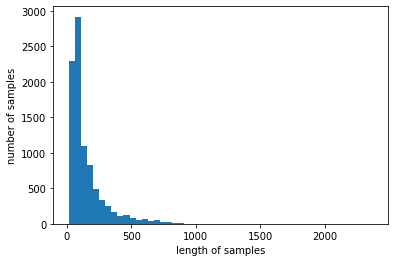

In [5]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [6]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

557056/550378 [==============================] - 0s 0us/step


In [7]:
index_to_word = {index + 3 : word for word, index in word_index.items()}

In [8]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [9]:
x_train[0]

[1,
 27595,
 28842,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [10]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


 - 전체 데이터 변환(train, test)

In [11]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [12]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

## 2. 벡터화 하기
 - Document Term Matrix, DTM을 활용한 TF-IDF행렬로 벡터화한다.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#### DTM 생성

In [14]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


#### TF-IDF 생성

In [15]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


## 3. 머신러닝 모델 학습
 - 나이브 베이즈 분류기
 - Complement Naive Bayes Classifier, CNB
 - 로지스틱 회귀
 - 서포트 벡터 머신(SVM)
 - 결정 트리
 - 랜덤 포레스트
 - 그래디언트 부스팅 트리
 - 보팅

In [16]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

 - tain데이터를 TF-IDF행렬로 변환한 것처럼 test데이터도 변환합니다.
 - 정확도를 측정하기 위함

In [18]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

In [19]:
def train_ml(tfidfv, y_train, tfidfv_test, y_test):
    # 나이브 베이즈 분류기 
    mod = MultinomialNB()
    mod.fit(tfidfv, y_train)
    
    mod_predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("나이브 베이즈 정확도:", accuracy_score(y_test, mod_predicted)) #예측값과 실제값 비교
    
    # CNB
    cb = ComplementNB()
    cb.fit(tfidfv, y_train)
    
    cb_predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("CNB 정확도:", accuracy_score(y_test, cb_predicted)) #예측값과 실제값 비교
    
    # 로지스틱 회귀 
    lr = LogisticRegression(C=10000, penalty='l2')
    lr.fit(tfidfv, y_train)

    lr_predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("로지스틱 회귀 정확도:", accuracy_score(y_test, lr_predicted)) #예측값과 실제값 비교
    
    # 선형 서포트 벡터 머신 
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
    lsvc.fit(tfidfv, y_train)
    
    lsvc_predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("SVM 정확도:", accuracy_score(y_test, lsvc_predicted)) #예측값과 실제값 비교
    
    # 결정 트리(Decision Tree) 
    tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    tree.fit(tfidfv, y_train)
    
    tree_predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("결정 트리 정확도:", accuracy_score(y_test, tree_predicted)) #예측값과 실제값 비교
    
    # 랜덤 포레스트(Random Forest)
    forest = RandomForestClassifier(n_estimators=5, random_state=0)
    forest.fit(tfidfv, y_train)
    
    forest_predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("랜덤 포레스트 정확도:", accuracy_score(y_test, forest_predicted)) #예측값과 실제값 비교
    
    # 그래디언트 부스팅 트리(GradientBoostingClassifier)
    grbt = GradientBoostingClassifier(random_state=0, verbose=3) # verbose=3
    grbt.fit(tfidfv, y_train)

    grbt_predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("그래디언트 부스팅 트리 정확도:", accuracy_score(y_test, grbt_predicted)) #예측값과 실제값 비교
    
    # 보팅(Voting)
    voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
        ], voting='soft', n_jobs=-1)
    voting_classifier.fit(tfidfv, y_train)
    
    voting_classifier_predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("보팅 정확도:", accuracy_score(y_test, voting_classifier_predicted)) #예측값과 실제값 비교
    
    return mod, cb, lr, lsvc, tree, forest, grbt, voting_classifier

In [20]:
mod, cb, lr, lsvc, tree, forest, grbt, voting_classifier = train_ml(tfidfv, y_train, tfidfv_test, y_test)


나이브 베이즈 정확도: 0.5997328584149599
CNB 정확도: 0.7649154051647373


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.813446126447017


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.7845057880676759
결정 트리 정확도: 0.6211041852181657
랜덤 포레스트 정확도: 0.6544968833481746
      Iter       Train Loss   Remaining Time 
         1       12845.1851           18.79m
         2   689466281.7264           18.70m
         3 6884613407215.1387           18.50m
         4 5935818824582923550720.0000           18.33m
         5 9040644020576697454476775298309462042959687372080133879675061827235923374847613060426279764553817024942513812241979907601155443654656.0000           18.20m
         6 9040644020576697454476775298309462042959687372080133879675061827235923374847613060426279764553817024942513812241979907601155443654656.0000           18.02m
         7 9040644020576697454476775298309462042959687372080133879675061827235923374847613060426279764553817024942513812241979907601155443654656.0000           17.83m
         8 9040644020576697454476775298309462042959687372080133879675061827235923374847613060426279764553817024942513812241979907601155443654656.0000           17.63m
   

#### (2) 단어 5000개 사용

In [21]:
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [22]:
decoded = []
for i in range(len(x_train_5k)):
    t = ' '.join([index_to_word[index] for index in x_train_5k[i]])
    decoded.append(t)

x_train_5k = decoded

In [23]:
decoded = []
for i in range(len(x_test_5k)):
    t = ' '.join([index_to_word[index] for index in x_test_5k[i]])
    decoded.append(t)

x_test_5k = decoded

 - 행렬 변환

In [24]:
dtmvector = CountVectorizer()
x_train_dtm_5k = dtmvector.fit_transform(x_train_5k)
print(x_train_dtm_5k.shape)

(8982, 4867)


In [25]:
tfidf_transformer = TfidfTransformer()
tfidfv_5k = tfidf_transformer.fit_transform(x_train_dtm_5k)
print(tfidfv_5k.shape)

(8982, 4867)


In [26]:
x_test_dtm_5k = dtmvector.transform(x_test_5k) # 테스트 데이터를 DTM으로 변환
tfidfv_test_5k = tfidf_transformer.transform(x_test_dtm_5k) # DTM을 TF-IDF 행렬로 변환

In [27]:
import time
start = time.time() 

mod_5k, cb_5k, lr_5k, lsvc_5k, tree_5k, forest_5k, grbt_5k, voting_classifier_5k = train_ml(tfidfv_5k, y_train_5k, tfidfv_test_5k, y_test_5k)

print("time :", time.time() - start)

나이브 베이즈 정확도: 0.6731967943009796
CNB 정확도: 0.7707034728406055


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.8058771148708815


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.7680320569902048
결정 트리 정확도: 0.6179875333926982
랜덤 포레스트 정확도: 0.701246660730187
      Iter       Train Loss   Remaining Time 
         1       13200.9090           17.72m
         2 19141531432.3860           17.64m
         3 1018136056482137345428864037762575643679300980036667356656533462569269067776.0000           17.60m
         4 5793438208146438552371750463374243580454084126740516228669142075250525372030044080110043136.0000           17.36m
         5 3979630484381169793867261128601856110593550227404752540847489843154493525639763256294740889013872088305157670725524817116093080321688237768704.0000           17.19m
         6 3979630484381169793867261128601856110593550227404752540847489843154493525639763256294740889013872088305157670725524817116093080321688237768704.0000           17.01m
         7 3979630484381169793867261128601856110593550227404752540847489843154493525639763256294740889013872088305157670725524817116093080321688237768704.0000           16.86m
         8 3

## (3-1) 단어 1000개 사용

In [28]:
(x_train_1k, y_train_1k), (x_test_1k, y_test_1k) = reuters.load_data(num_words=1000, test_split=0.2)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [29]:
decoded = []
for i in range(len(x_train_1k)):
    t = ' '.join([index_to_word[index] for index in x_train_1k[i]])
    decoded.append(t)

x_train_1k = decoded

In [30]:
decoded = []
for i in range(len(x_test_1k)):
    t = ' '.join([index_to_word[index] for index in x_test_1k[i]])
    decoded.append(t)

x_test_1k = decoded

 - 행렬 변환

In [31]:
dtmvector = CountVectorizer()
x_train_dtm_1k = dtmvector.fit_transform(x_train_1k)
print(x_train_dtm_1k.shape)

(8982, 969)


In [32]:
tfidf_transformer = TfidfTransformer()
tfidfv_1k = tfidf_transformer.fit_transform(x_train_dtm_1k)
print(tfidfv_1k.shape)

(8982, 969)


In [33]:
x_test_dtm_1k = dtmvector.transform(x_test_1k) #테스트 데이터를 DTM으로 변환
tfidfv_test_1k = tfidf_transformer.transform(x_test_dtm_1k) #DTM을 TF-IDF 행렬로 변환

In [34]:
import time
import datetime

start = time.time() 

mod_1k, cb_1k, lr_1k, lsvc_1k, tree_1k, forest_1k, grbt_1k, voting_classifier_1k = train_ml(tfidfv_1k, y_train_1k, tfidfv_test_1k, y_test_1k)


sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6856634016028496
CNB 정확도: 0.7346393588601959


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.780053428317008


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.7221727515583259
결정 트리 정확도: 0.6179875333926982
랜덤 포레스트 정확도: 0.707479964381122
      Iter       Train Loss   Remaining Time 
         1       14117.1745           15.15m
         2    35639162.1314           14.75m
         3    42705979.3760           14.48m
         4  9126252191.8651           14.31m
         5  9126424532.2802           14.11m
         6 62647635205.0903           13.87m
         7 62648065808.4197           13.72m
         8 62648065658.7994           13.60m
         9 608185690008282430912365147168569475398132500303209932316333183827805761102415935379079168.0000           13.45m
        10 608185690008282430912365147168569475398132500303209932316333183827805761102415935379079168.0000           13.28m
        11 608185690008282430912365147168569475398132500303209932316333183827805761102415935379079168.0000           13.13m
        12 608185690008282430912365147168569475398132500303209932316333183827805761102415935379079168.0000           12.96m
        1

## (3-2) 단어 10000개 사용

In [35]:
(x_train_10k, y_train_10k), (x_test_10k, y_test_10k) = reuters.load_data(num_words=10000, test_split=0.2)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [36]:
decoded = []
for i in range(len(x_train_10k)):
    t = ' '.join([index_to_word[index] for index in x_train_10k[i]])
    decoded.append(t)

x_train_10k = decoded

In [37]:
decoded = []
for i in range(len(x_test_10k)):
    t = ' '.join([index_to_word[index] for index in x_test_10k[i]])
    decoded.append(t)

x_test_10k = decoded

 - 행렬 변환

In [38]:
dtmvector = CountVectorizer()
x_train_dtm_10k = dtmvector.fit_transform(x_train_10k)
print(x_train_dtm_10k.shape)

(8982, 9670)


In [39]:
tfidf_transformer = TfidfTransformer()
tfidfv_10k = tfidf_transformer.fit_transform(x_train_dtm_10k)
print(tfidfv_10k.shape)

(8982, 9670)


In [40]:
x_test_dtm_10k = dtmvector.transform(x_test_10k) #테스트 데이터를 DTM으로 변환
tfidfv_test_10k = tfidf_transformer.transform(x_test_dtm_10k) #DTM을 TF-IDF 행렬로 변환

In [41]:
start = time.time() 

mod_10k, cb_10k, lr_10k, lsvc_10k, tree_10k, forest_10k, grbt_10k, voting_classifier_10k = train_ml(tfidfv_10k, y_train_10k, tfidfv_test_10k, y_test_10k)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6567230632235085
CNB 정확도: 0.7707034728406055


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.8076580587711487


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.780053428317008
결정 트리 정확도: 0.6202137132680321
랜덤 포레스트 정확도: 0.674087266251113
      Iter       Train Loss   Remaining Time 
         1       13120.6334           17.33m
         2   858177598.4933           17.29m
         3   946802549.6393           17.18m
         4 237936546535516355390923778577443137004998111350751232.0000           17.04m
         5 29932193976389972415457316369798088344148526429337375113230188232847921979331343979616204345474359412007156081620446930232527552512.0000           16.90m
         6 29932193976389972415457316369798088344148526429337375113230188232847921979331343979616204345474359412007156081620446930232527552512.0000           16.75m
         7 29932193976389972415457316369798088344148526429337375113230188232847921979331343979616204345474359412007156081620446930232527552512.0000           16.58m
         8 29932193976389972415457316369798088344148526429337375113230188232847921979331343979616204345474359412007156081620446930232527552512.0000 

## (3-3) 단어 20000개 사용

In [42]:
(x_train_20k, y_train_20k), (x_test_20k, y_test_20k) = reuters.load_data(num_words=20000, test_split=0.2)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [43]:
decoded = []
for i in range(len(x_train_20k)):
    t = ' '.join([index_to_word[index] for index in x_train_20k[i]])
    decoded.append(t)

x_train_20k = decoded

In [44]:
decoded = []
for i in range(len(x_test_20k)):
    t = ' '.join([index_to_word[index] for index in x_test_20k[i]])
    decoded.append(t)

x_test_20k = decoded

 - 행렬 변환

In [45]:
dtmvector = CountVectorizer()
x_train_dtm_20k = dtmvector.fit_transform(x_train_20k)
print(x_train_dtm_20k.shape)

(8982, 18479)


In [46]:
tfidf_transformer = TfidfTransformer()
tfidfv_20k = tfidf_transformer.fit_transform(x_train_dtm_20k)
print(tfidfv_20k.shape)

(8982, 18479)


In [47]:
x_test_dtm_20k = dtmvector.transform(x_test_20k) #테스트 데이터를 DTM으로 변환
tfidfv_test_20k = tfidf_transformer.transform(x_test_dtm_20k) #DTM을 TF-IDF 행렬로 변환

In [48]:
start = time.time() 

mod_20k, cb_20k, lr_20k, lsvc_20k, tree_20k, forest_20k, grbt_20k, voting_classifier_20k = train_ml(tfidfv_20k, y_train_20k, tfidfv_test_20k, y_test_20k)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6193232413178985
CNB 정확도: 0.7671415850400712


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.8098842386464826


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.776046304541407
결정 트리 정확도: 0.6211041852181657
랜덤 포레스트 정확도: 0.6714158504007124
      Iter       Train Loss   Remaining Time 
         1       12866.7674           19.01m
         2   857110564.4706           18.81m
         3   948235166.2435           18.58m
         4 5328338531245606567936.0000           18.38m
         5 33901976731661941304447968959860882059472513393295849800957907615488399548773525845286716013123295545152344093297951468068227367567360.0000           18.19m
         6 33901976731661941304447968959860882059472513393295849800957907615488399548773525845286716013123295545152344093297951468068227367567360.0000           18.01m
         7 13379126834942043802209105779833373942873421885839179130825482861179199956624012499382910774006716943351801331609300997275675840013550615692243369984.0000           17.82m
         8 133791268349420438022091057798333739428734218858391791308254828611791999566240124993829107740067169433518013316093009972756758400135506156922433

## 성능 평가

각 vocab size별 모델의 정확도를 이용해 성능을 평가한다.


#### 전체 단어 
 - 나이브 베이즈 정확도: 0.5997328584149599 
 - CNB 정확도: 0.7649154051647373 
 - 로지스틱 회귀 정확도: 0.813446126447017 
 - SVM 정확도: 0.784060552092609 
 - 결정 트리 정확도: 0.6211041852181657 
 - 랜덤 포레스트 정확도: 0.6544968833481746 
 - 그래디언트 부스팅 트리 정확도: 0.7702582368655387 
 - 보팅 정확도: 0.8187889581478184
--> 전체단어 보팅 정확도 (0.8187889581478184)이 best

#### 5000개 
 - 나이브 베이즈 정확도: 0.6731967943009796 
 - CNB 정확도: 0.7707034728406055 
 - 로지스틱 회귀 정확도: 0.8058771148708815 
 - SVM 정확도: 0.7666963490650045 
 - 결정 트리 정확도: 0.6179875333926982 
 - 랜덤 포레스트 정확도: 0.701246660730187 
 - 그래디언트 부스팅 트리 정확도: 0.767586821015138 
 - 보팅 정확도: 0.8161175422974176

#### 1000개 
- 나이브 베이즈 정확도: 0.6856634016028496 
- CNB 정확도: 0.7346393588601959 
- 로지스틱 회귀 정확도: 0.780053428317008 
- SVM 정확도: 0.7172751558325913 
- 결정 트리 정확도: 0.6179875333926982 
- 랜덤 포레스트 정확도: 0.707479964381122 
- 그래디언트 부스팅 트리 정확도: 0.7457702582368655 
- 보팅 정확도: 0.7845057880676759

#### 10000개 
- 나이브 베이즈 정확도: 0.6567230632235085
- CNB 정확도: 0.7707034728406055 
- 로지스틱 회귀 정확도: 0.8076580587711487 
- SVM 정확도: 0.7813891362422084 
- 결정 트리 정확도: 0.6202137132680321 
- 랜덤 포레스트 정확도: 0.674087266251113 
- 그래디언트 부스팅 트리 정확도: 0.7666963490650045 
- 보팅 정확도: 0.8116651825467498

#### 20000개 
- 나이브 베이즈 정확도: 0.6193232413178985 
- CNB 정확도: 0.7671415850400712 
- 로지스틱 회귀 정확도: 0.8098842386464826 
- SVM 정확도: 0.7778272484416741 
- 결정 트리 정확도: 0.6211041852181657 
- 랜덤 포레스트 정확도: 0.6714158504007124 
- 그래디언트 부스팅 트리 정확도: 0.769813000890472 
- 보팅 정확도: 0.8178984861976848

In [49]:
bayse = [0.5997328584149599, 0.6731967943009796, 0.6856634016028496, 0.6567230632235085, 0.6193232413178985]
cnb = [0.7649154051647373, 0.7707034728406055, 0.7346393588601959, 0.7707034728406055, 0.7671415850400712]
logistic = [0.813446126447017, 0.8058771148708815, 0.7346393588601959, 0.7707034728406055, 0.7671415850400712]
svm = [0.784060552092609, 0.7666963490650045, 0.7172751558325913, 0.7813891362422084, 0.7778272484416741]
tree = [0.6211041852181657, 0.6179875333926982, 0.6179875333926982, 0.6202137132680321, 0.6211041852181657]
rf = [0.6544968833481746, 0.701246660730187, 0.707479964381122, 0.674087266251113, 0.6714158504007124]
gbs = [0.7702582368655387, 0.767586821015138, 0.7457702582368655, 0.7666963490650045, 0.769813000890472]
voting = [0.8187889581478184, 0.8161175422974176, 0.7845057880676759, 0.8116651825467498, 0.8178984861976848]

vocab_size_list = ['whole', '5k', '1k', '10k', '20k']
model_list = [bayse, cnb, logistic, svm, tree, rf, gbs, voting]

In [50]:
acc_dict = {}
for idx, vs in enumerate(vocab_size_list):
    acc_list = []
    for model in model_list:
        acc_list.append(model[idx])
    acc_dict[vs] = sum(acc_list)/len(model_list)

In [51]:
acc_dict

{'whole': 0.7283504007123776,
 '5k': 0.7399265360641141,
 '1k': 0.7159951024042743,
 '10k': 0.7315227070347284,
 '20k': 0.7264581478183436}

### 각 모델의 정확도 확인 결과, 5000개의 단어 개수가 가장 정확도가 높았음을 알 수 있었다.

## 4. 딥러닝 모델 학습

In [52]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Input, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


vocab_size = 5000
word_vector_dim = 32  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim))
model_LSTM.add(keras.layers.LSTM(32))
# model_LSTM.add(keras.layers.Dense(128, activation='relu'))  
model_LSTM.add(keras.layers.Dense(num_classes, activation='softmax'))  

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 46)                1518      
Total params: 169,838
Trainable params: 169,838
Non-trainable params: 0
_________________________________________________________________


In [53]:
tfidfv_5k.shape, y_train_5k.shape

((8982, 4867), (8982,))

## 학습 데이터 실험
sparse한 행렬을 dense하게 만들기 위해 두가지 변환으로 실험
toarray() : array로 변환(에러메세지에서 추천하는 방법)
todense() : Return a dense matrix representation of this matrix.

In [54]:
tfidfv_20k_arr = tfidfv_20k.toarray()
tfidfv_20k_dense = tfidfv_20k.todense()

In [55]:
tfidfv_test_20k_arr = tfidfv_test_20k.toarray()
tfidfv_test_20k_dense = tfidfv_test_20k.todense()

In [56]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


model_LSTM.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
            
epochs=20
batch_size=64


history_LSTM = model_LSTM.fit(tfidfv_20k_arr,
                                y_train_20k,
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[es, mc],
                                validation_split=0.2,
                                verbose=1)

Epoch 1/20
113/113 [==============================] - 183s 2s/step - loss: 3.2467 - accuracy: 0.2874 - val_loss: 2.4098 - val_accuracy: 0.3450
Epoch 2/20
113/113 [==============================] - 180s 2s/step - loss: 2.4288 - accuracy: 0.3468 - val_loss: 2.4091 - val_accuracy: 0.3450
Epoch 3/20
113/113 [==============================] - 180s 2s/step - loss: 2.3928 - accuracy: 0.3616 - val_loss: 2.4044 - val_accuracy: 0.3450
Epoch 4/20
113/113 [==============================] - 180s 2s/step - loss: 2.4190 - accuracy: 0.3492 - val_loss: 2.4080 - val_accuracy: 0.3450
Epoch 5/20
113/113 [==============================] - 180s 2s/step - loss: 2.3995 - accuracy: 0.3584 - val_loss: 2.4047 - val_accuracy: 0.3450
Epoch 6/20
113/113 [==============================] - 180s 2s/step - loss: 2.4099 - accuracy: 0.3516 - val_loss: 2.4166 - val_accuracy: 0.3450
Epoch 7/20
113/113 [==============================] - 180s 2s/step - loss: 2.3967 - accuracy: 0.3541 - val_loss: 2.4052 - val_accuracy: 0.3450

In [57]:
results = model_LSTM.evaluate(tfidfv_test_20k_arr,  y_test_20k, verbose=2)
print(results)

71/71 - 43s - loss: 2.4150 - accuracy: 0.3620
[2.415040969848633, 0.36197686195373535]


In [58]:
from tensorflow import keras

vocab_size = 20000
word_vector_dim = 32  

model_LSTM_dense = keras.Sequential()
model_LSTM_dense.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim))
model_LSTM_dense.add(keras.layers.LSTM(32))
# model_LSTM_dense.add(keras.layers.Dense(128, activation='relu'))  
model_LSTM_dense.add(keras.layers.Dense(num_classes, activation='softmax'))  

model_LSTM_dense.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                1518      
Total params: 649,838
Trainable params: 649,838
Non-trainable params: 0
_________________________________________________________________


In [60]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


model_LSTM_dense.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
            
epochs=20
batch_size=64

history_LSTM_dense = model_LSTM_dense.fit(tfidfv_20k_dense,
                                y_train_20k,
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[es],
                                validation_split=0.2,
                                verbose=1)

Epoch 1/20
113/113 [==============================] - 183s 2s/step - loss: 3.2383 - accuracy: 0.1952 - val_loss: 2.4145 - val_accuracy: 0.3450
Epoch 2/20
113/113 [==============================] - 182s 2s/step - loss: 2.4133 - accuracy: 0.3527 - val_loss: 2.4086 - val_accuracy: 0.3450
Epoch 3/20
113/113 [==============================] - 181s 2s/step - loss: 2.3855 - accuracy: 0.3524 - val_loss: 2.4068 - val_accuracy: 0.3450
Epoch 4/20
113/113 [==============================] - 180s 2s/step - loss: 2.4037 - accuracy: 0.3556 - val_loss: 2.4044 - val_accuracy: 0.3450
Epoch 5/20
113/113 [==============================] - 180s 2s/step - loss: 2.4171 - accuracy: 0.3529 - val_loss: 2.4070 - val_accuracy: 0.3450
Epoch 6/20
113/113 [==============================] - 180s 2s/step - loss: 2.4326 - accuracy: 0.3466 - val_loss: 2.4061 - val_accuracy: 0.3450
Epoch 7/20
113/113 [==============================] - 180s 2s/step - loss: 2.4143 - accuracy: 0.3535 - val_loss: 2.4070 - val_accuracy: 0.3450

In [61]:
results_dense = model_LSTM_dense.evaluate(tfidfv_test_20k_dense,  y_test_20k, verbose=2)
print(results_dense)

71/71 - 43s - loss: 2.4172 - accuracy: 0.3620
[2.417243003845215, 0.36197686195373535]


 - toarray() : [2.4173861999970296, 0.36197686]
 - todense() : [2.415727226625886, 0.36197686]
##### toarray(), todense()로 학습한 결과 큰 차이가 나지 않았다.

인풋에 대해 sparse함을 확인할 수 있는 scipy의 issparse를 이용해 확인한다.

In [63]:
from scipy import sparse 

sparse.issparse(tfidfv_test_20k_dense)

False

In [64]:
sparse.issparse(tfidfv_test_20k_arr)

False

 - toarray(), todense() 모두 sparse했던 행렬을 dense하게 변환시킨 것을 확인했다.
 - TF-IDF행렬로 vectorizing한 input을 사용하기 때문에 행렬형태인 todense()의 결과를 모델에 사용하겠다.


## 성능 향상
모델의 레이어를 추가하며 accuracy를 향상시킨다.

In [65]:
from tensorflow import keras

def rnn(num_layer=8):

    model_dense = keras.Sequential()
    model_dense.add(keras.layers.Dense(num_layer*4, activation='relu', input_shape=(tfidfv_20k_dense.shape[1],)))  
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    
    
    model_dense.add(keras.layers.Dense(num_layer*8, activation='relu')) 
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    
    model_dense.add(keras.layers.Dense(num_layer*16, activation='relu')) 
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    
    model_dense.add(keras.layers.Dense(num_layer*32, activation='relu'))
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    
    
    model_dense.add(keras.layers.Dense(num_classes, activation='softmax'))  
    model_dense.summary()
    
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


    model_dense.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    epochs=20
    batch_size=128

    history_dense = model_dense.fit(tfidfv_20k_dense,
                                    y_train_20k,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    callbacks=[es, mc],
                                    validation_split=0.2,
                                    verbose=1)
    
    results = model_dense.evaluate(tfidfv_test_20k_dense,  y_test_20k, verbose=2)
    print(results)
    
    return history_dense, model_dense

In [66]:
history_dense, model_dense = rnn_modified()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                591360    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [67]:
def visualize_train(train_history):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

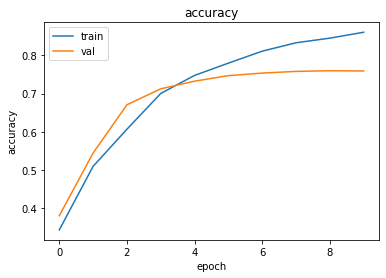

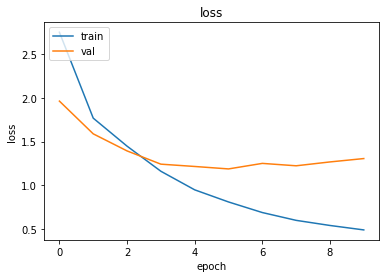

In [68]:
visualize_train(history_dense)

In [69]:
model_dense.predict(tfidfv_test_20k_dense)

array([[4.3479154e-08, 1.4843771e-04, 2.7147373e-09, ..., 4.5284820e-10,
        4.0590011e-11, 3.4022829e-10],
       [9.4876852e-04, 1.2411555e-02, 9.8921247e-03, ..., 4.4944923e-06,
        3.2178895e-07, 7.5185466e-07],
       [1.9688022e-04, 9.3780547e-01, 1.1617739e-03, ..., 5.1124114e-09,
        1.1643597e-09, 2.8083464e-09],
       ...,
       [8.6590145e-14, 1.9877513e-07, 9.1836646e-16, ..., 1.0345615e-16,
        2.6438185e-18, 6.7981362e-17],
       [3.3116052e-03, 1.4897972e-02, 8.2487304e-04, ..., 2.9533951e-05,
        1.5518155e-05, 5.0833467e-05],
       [1.0733594e-02, 4.1456625e-01, 3.7689228e-02, ..., 3.5071280e-05,
        1.6617530e-05, 2.9000454e-05]], dtype=float32)

In [70]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test_20k, model_dense.predict(tfidfv_test_20k_dense).argmax(axis=1)))


              precision    recall  f1-score   support

           0       0.40      0.50      0.44        12
           1       0.68      0.77      0.72       105
           2       0.62      0.40      0.48        20
           3       0.89      0.93      0.91       813
           4       0.83      0.87      0.85       474
           5       0.00      0.00      0.00         5
           6       0.32      0.43      0.36        14
           7       0.00      0.00      0.00         3
           8       0.48      0.68      0.57        38
           9       0.57      0.68      0.62        25
          10       0.77      0.77      0.77        30
          11       0.64      0.67      0.66        83
          12       0.22      0.15      0.18        13
          13       0.52      0.73      0.61        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.63      0.75      0.68        99
          17       0.40    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Flatten, BatchNormalization

def rnn_modified(num_layer=8):
    model_dense = keras.Sequential()
    model_dense.add(keras.layers.Dense(num_layer*4, activation='relu', input_shape=(tfidfv_20k_dense.shape[1],)))  
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    
    
    model_dense.add(keras.layers.Dense(num_layer*8, activation='relu')) 
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    
    model_dense.add(keras.layers.Dense(num_layer*16, activation='relu')) 
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    
    model_dense.add(keras.layers.Dense(num_layer*32, activation='relu'))
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    
    model_dense.add(keras.layers.Dense(num_layer*64, activation='relu'))
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    
    model_dense.add(keras.layers.Dense(num_layer*128, activation='relu'))
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    
    model_dense.add(keras.layers.Dense(num_layer*64, activation='relu'))
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    model_dense.add(keras.layers.BatchNormalization()),
    
    model_dense.add(keras.layers.Dense(num_classes, activation='softmax'))  
    model_dense.summary()
    
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


    model_dense.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    epochs=20
    batch_size=128

    history_dense = model_dense.fit(tfidfv_20k_dense,
                                    y_train_20k,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    callbacks=[es, mc],
                                    validation_split=0.2,
                                    verbose=1)
    
    results = model_dense.evaluate(tfidfv_test_20k_dense,  y_test_20k, verbose=2)
    print(results)
    
    return history_dense, model_dense

In [80]:
history_dense, model_dense = rnn_modified()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 32)                591360    
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)              

In [83]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Flatten, BatchNormalization

def rnn_modified(num_layer=8):
    model_dense = keras.Sequential()
    model_dense.add(keras.layers.Dense(num_layer*4, activation='relu', input_shape=(tfidfv_20k_dense.shape[1],)))  
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    model_dense.add(keras.layers.BatchNormalization()),
    
    
    model_dense.add(keras.layers.Dense(num_layer*8, activation='relu')) 
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    model_dense.add(keras.layers.BatchNormalization()),
    
    model_dense.add(keras.layers.Dense(num_layer*16, activation='relu')) 
    model_dense.add(keras.layers.Dropout(0.2)),
    model_dense.add(keras.layers.Flatten()),
    model_dense.add(keras.layers.BatchNormalization()),
    
    model_dense.add(keras.layers.Dense(num_classes, activation='softmax'))  
    model_dense.summary()
    
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


    model_dense.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    epochs=20
    batch_size=128

    history_dense = model_dense.fit(tfidfv_20k_dense,
                                    y_train_20k,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    callbacks=[es, mc],
                                    validation_split=0.2,
                                    verbose=1)
    
    results = model_dense.evaluate(tfidfv_test_20k_dense,  y_test_20k, verbose=2)
    print(results)
    
    return history_dense, model_dense

In [84]:
history_dense, model_dense = rnn_modified()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                591360    
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 64)               

In [85]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test).argmax(axis=1)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

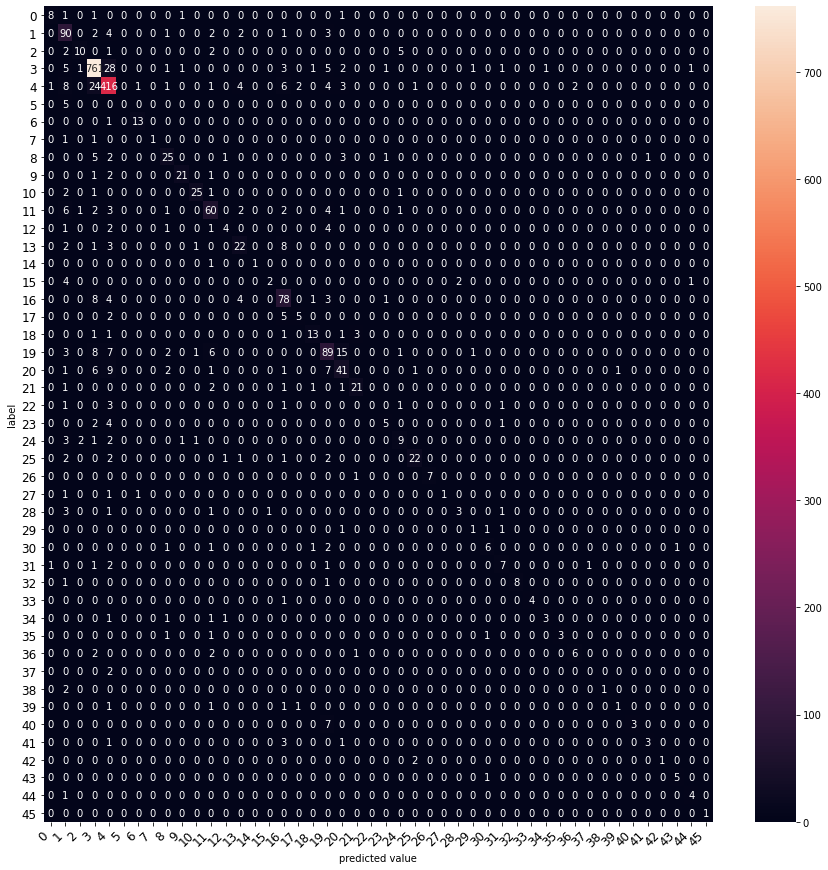

In [86]:
graph_confusion_matrix(model_dense, tfidfv_test_20k_dense, y_test_20k)

## 루브릭 평가
분류 모델의 accuracy가 기준 이상 높게 나왔는가?

- 5가지의 경우를 테스트하고 모델 별 accuracy를 확인했다.


분류 모델의 F1 score가 기준 이상 높게 나왔는가?

 - f1 score를 출력해 높게 나온 것을 확인할 수 있었다.


생성모델의 metric(BLEU 등) 기준 이상 높은 성능이 확인되었는가?

 - confusion matrix, f1 score, 딥러닝 모델의 경우 test dataset의 accuracy를 확인했고, 기준 이상의 높은 성능을 확인했다.

## 회고


#### 전체 단어 
- whole': 0.7283504007123776,


#### 5000개 
 - '5k': 0.7399265360641141,

#### 1000개 
 - '1k': 0.7159951024042743,

#### 10000개 
 -  '10k': 0.7315227070347284,

#### 20000개 
 - '20k': 0.7264581478183436}


#### LSTM only
 - loss: 2.4150 - accuracy: 0.3620

#### LSTM + Dense
[loss = 2.417243003845215, acc = 0.36197686195373535]

#### RNN
[loss = 1.4193588495254517, acc = 0.7506678700447083]

#### RNN modified (my own)
[loss = 1.1477466821670532, acc = 0.8058770895004272]

#### 어려웠던 부분
 - 기본 나이브 베이스도 시간이 약 1시간 걸린거 같은데 머신러닝의 경우 학습시간이 훨씬훨씬 오래걸렸다


#### 알아낸 점 혹은 모호한 부분

- 단어수를 학습할 때 불러올 수 있는점이 신기했다. 이 단어들을 잘못 가져오면 데이터가 안 좋을 줄 알았는데 오히려 5천개가 더 잘나왔네?? 예상하지 못한 결과로 더욱 더 궁금해졌다.

- 예상했던대로 RNN이 제일 잘 나왔다. RNN 모델을 조금 더 수정해서 더 정확도가 높은 모델을 만들어보고 싶다.


- DTM과 TF-IDF를 사용하면 다양한 클래시컬 머신러닝(random forest등) 기법들을 사용할 수 있다는 점을 알게 되었다.


- 솔직하게 말해서 주제를 분류하는 classification을 위해서 LSTM과 RNN이 어떻게 사용된건지 잘 모르겠다. 마지막 레이어의 노드 갯수를 num_classes로 맞춰주기만 하면 되는건가? 나중에 추가로 탐구해보겠다.  

 - 흥미로웠던 점은 image classification에서 주로 쓰이던 Dense layers딥러닝 기법이 혼합된 RNN이 가장 점수가 높았다는 점이다.
 
 - 폐렴노드와 캐글 이미지분류에서 쓰이던 dropout, batchnormalization을 추가로 사용한 나만의 modified rnn에서 정확도 0.8058770895004272를 달성했다.
 
 
 - 처음에 rnn으로만 그래프를 그린 graph_confusion_matrix에서 4번이 412가 나오는 특이한 점수를 가졌다. 이는 outlier가 아닐까 의심될정도로 숫자가 높다. 나머지 16번, 29번들이 그나마 각각 74점, 99점으로 높은 점수였다. 이 점수들이 나온 이유가 뭘까?
 
 ## 참고자료
 
 ## Reference 

1) https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-06%5Dword_embedding_association_WEAT.ipynb

2) https://piaojian.tistory.com/37

In [73]:
print('the end')

the end
